<span>
<b>Author:</b> <a href="http://pages.di.unipi.it/ruggieri/">Salvatore Ruggieri</a><br/>
<b>Python version:</b>  3.x<br/>
</span>
required modules: <b>pyroaring, pyfim</b>

<code>
> pip install pyroaring
> conda install -c conda-forge pyfim
</code>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import discrimination_discovery
import pandas as pd

In [3]:
# Sample data: credit.csv, adult.csv or any other dataset with discrete columns only.
df = pd.read_csv("data/credit.csv", sep=',', na_values='?')
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,lt_0,le_17d6,critical_or_other_existing_credit,radio_or_tv,le_38848d8,no_known_savings,ge_7,gt_2d8,male_single,none,...,real_estate,gt_52d6,none,own,from_1d6_le_2d2,skilled,le_1d2,yes,yes,good
1,from_0_lt_200,gt_31d2,existing_paid,radio_or_tv,from_38848d8_le_7519d6,lt_100,from_1_lt_4,from_1d6_le_2d2,female_div_or_dep_or_mar,none,...,real_estate,le_30d2,none,own,le_1d6,skilled,le_1d2,none,yes,bad
2,no_checking,le_17d6,critical_or_other_existing_credit,education,le_38848d8,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,none,...,real_estate,from_41d4_le_52d6,none,own,le_1d6,unskilled_resident,gt_1d2,none,yes,good
3,lt_0,gt_31d2,existing_paid,furniture_or_equipment,from_7519d6_le_11154d4,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,guarantor,...,life_insurance,from_41d4_le_52d6,none,for_free,le_1d6,skilled,gt_1d2,none,yes,good
4,lt_0,from_17d6_le_31d2,delayed_previously,new_car,from_38848d8_le_7519d6,lt_100,from_1_lt_4,gt_2d8,male_single,none,...,no_known_property,gt_52d6,none,for_free,from_1d6_le_2d2,skilled,gt_1d2,none,yes,bad


In [4]:
# DD(filename, unprotected item, negative decision)
disc = dd.DD(df, 'foreign_worker=no', 'class=bad')

In [5]:
# filtering condition: return None to filter out, or measure value
# contingency table
# =========== dec- ==== dec+ === tot
# protected    a         b       n1()
# unprotect.   c         d       n2()
# ===========  m1()  ====  m2()  === n()
def check_rd(ctg):
    # at least 20 protected with negative decision and 20 unprotected in total
    if ctg.a < 20 or ctg.n2() < 20:
        return None
    v = ctg.rd()
    # risk difference greater than 0.1
    return v if v > 0.1 else None

In [6]:
# Extract contingency tables: 
# minSupp = min support of context (negative = absolute, positive = percentage)
# maxn = top n contingency tables
ctgs = disc.extract(testCond=check_rd, minSupp=-20, maxn=100)

In [7]:
# print top 2
for v, ctg in ctgs[:2]:
    disc.print(ctg)
    print("RD = {:f}".format(v))

-----
B = purpose=new_car AND own_telephone=none AND credit_amount=le_38848d8
                  |class=bad|class=good|   
foreign_worker=yes|       49|        54|103
foreign_worker=no |        1|        19| 20
                  |       50|        73|123
RD = 0.425728
-----
B = purpose=new_car AND own_telephone=none
                  |class=bad|class=good|   
foreign_worker=yes|       59|        68|127
foreign_worker=no |        1|        19| 20
                  |       60|        87|147
RD = 0.414567


In [8]:
# Adult dataset

#df = pd.read_csv("adult.csv", sep=',', na_values='?')
#disc = dd.DD(df, 'sex=Male', 'class=-50K') 
# or
disc = dd.DD('data/adult_discrete.csv', 'sex=Male', 'class=-50K', na_values='?')

In [9]:
ctgs_rd = disc.extract(testCond=lambda ctg: (None if ctg.a < 20 or ctg.n2() < 20 else ctg.rd()), minSupp=-100, maxn=1000)
for v, ctg in ctgs_rd[:2]:
    disc.print(ctg)
    print("RD = {:f}".format(v))

-----
B = hours-per-week=(50.5-inf) AND occupation=Exec-managerial AND fnlwgt=(106068.5-157936.5] AND workclass=Private AND race=White
          |class=-50K|class=+50K|   
sex=Female|        20|         1| 21
sex=Male  |        21|        83|104
          |        41|        84|125
RD = 0.750458
-----
B = hours-per-week=(50.5-inf) AND occupation=Exec-managerial AND fnlwgt=(106068.5-157936.5] AND workclass=Private AND capital-gain=(-inf-57]
          |class=-50K|class=+50K|   
sex=Female|        20|         1| 21
sex=Male  |        25|        61| 86
          |        45|        62|107
RD = 0.661683


In [10]:
ctgs_rr = disc.extract(testCond=lambda ctg: (None if ctg.a < 20 or ctg.n2() < 20 else ctg.rr()), minSupp=-100, maxn=1000)
for v, ctg in ctgs_rr[:2]:
    disc.print(ctg)
    print("RR = {:f}".format(v))

-----
B = education-num=(13.5-inf) AND occupation=Prof-specialty AND age=(41.5-50.5] AND fnlwgt=(106068.5-157936.5]
          |class=-50K|class=+50K|   
sex=Female|        30|        15| 45
sex=Male  |        14|       102|116
          |        44|       117|161
RR = 5.523810
-----
B = education-num=(13.5-inf) AND occupation=Prof-specialty AND age=(41.5-50.5] AND fnlwgt=(106068.5-157936.5] AND race=White AND native-country=United-States
          |class=-50K|class=+50K|   
sex=Female|        23|        12| 35
sex=Male  |        12|        85| 97
          |        35|        97|132
RR = 5.311905


In [11]:
# contingency tables in ctgs_rd
ct_rd_set = set(ctg[1] for ctg in ctgs_rd)
# contingency tables in ctgs_rd
ct_rr_set = set(ctg[1] for ctg in ctgs_rr)

# how many in both
shared = ct_rd_set & ct_rr_set
len(shared) 

441

Text(0, 0.5, 'p2')

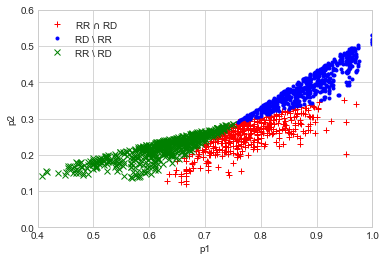

In [12]:
# plot p1() vs p2()
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.xlim(0.4, 1)
plt.ylim(0, 0.6)
plt.plot([ctg.p1() for ctg in shared], [ctg.p2() for ctg in shared], '+', color='red', label=r'RR $\cap$ RD')
only_rd = ct_rd_set - shared
plt.plot([ctg.p1() for ctg in only_rd], [ctg.p2() for ctg in only_rd], '.', color='blue', label=r'RD \ RR')
only_rr = ct_rr_set - shared
plt.plot([ctg.p1() for ctg in only_rr], [ctg.p2() for ctg in only_rr], 'x', color='green', label=r'RR \ RD')
plt.legend()
plt.xlabel('p1')
plt.ylabel('p2')